- Create the final CSV with the comment text, ID, majority label, confidence scores.
- Prepare TestQuestion report and descriptive stats for the batch.

In [1]:
import pandas as pd
import os, sys
from collections import defaultdict

pd.set_option('display.max_colwidth', -1)

In [2]:
# Test Questions DataFrame:
tq_df = pd.read_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/data/TestQuestions.csv', 
                    lineterminator='\n')
tq_df.drop('label', axis=1, inplace=True)
TEST_QUESTIONS = tq_df['reply_id'].tolist()
print("We have {} test questions.".format(len(TEST_QUESTIONS)))

We have 350 test questions.


In [3]:
# Concatenate all data CSVs (excluding the test question):
dfs = []
path = '/home/ndg/users/sbagga1/unpalatable-questions/data_csvs/'
for fname in os.listdir(path):
    df = pd.read_csv(path+fname, lineterminator='\n')
    
    # Sanity check: make sure the line_terminator of Pandas doesn't mess things up
    number_of_rows = int(fname.split('.')[0].split('_')[-1]) # no. of rows there should be
    if df.shape[0] != number_of_rows:
        sys.exit("lineterminator Error: CSV not read properly")
        
    print("{} has {} rows".format(fname, df.shape))
    
    dfs.append(df)
    
print("TestQuestios.csv has {} rows".format(tq_df.shape))
dfs.append(tq_df)
MAIN_DF = pd.concat(dfs)
print("Before removing duplicates: ", MAIN_DF.shape)
MAIN_DF.drop_duplicates(subset='reply_id', inplace=True)
print("Final shape: ", MAIN_DF.shape)
MAIN_DF.head(2)

FE_run_900.csv has (900, 6) rows
batch_1_600.csv has (600, 6) rows
batch_3_6300.csv has (6300, 6) rows
batch_2_3600.csv has (3600, 6) rows
TestQuestios.csv has (350, 6) rows
Before removing duplicates:  (11750, 6)
Final shape:  (11406, 6)


,question,reply_text,comment_text,comment_id,reply_id,subreddit
0,Like who are the people posting in there?,Hey. \nWhat the fuck is up with /r/sweden \nLike who are the people posting in there? \nThat's scary as hell.,"And that was many years ago. Since then the state declared it ILLEGAL to note an offendors nationality or background, because that would be offensive.\n\nSo all the latest crime stats are blank numbers, no context. LIKE THAT WOULD BE IMPORTANT LOL",d22mbo4,d22rr63,The_Donald
1,Isn't carnal desires what make us the same as animals ?,Interesting point. Isn't carnal desires what make us the same as animals ?,"Probably the wrong sub for this but have you noticed the explicitly carnal focus of Islam's paradise? \n\nBuddhists seek enlightenment, Hindu and Sikh receive oneness with god (IIRC), Judaism and Christianity vary from being reunited with loved ones in a (the?) garden to being also united with god.",d1vlwod,d1vm9xc,The_Donald


### 1. Descriptive Stats
- Batch 1 = 100 HITs | Batch 2 = 400 HITs | Batch 3 = 700 HITs
- Note: the 50 extra rows in the DataFrame correspond to the 5 HITs that I approved in batch 1 (after overriding rejections)

In [4]:
mturk_df = pd.read_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/annotations/\
annotations_batch_1_2_3.tsv', delimiter='\t')
print(mturk_df.shape)
mturk_df.tail()

(60050, 5)


,Reply ID,Label,Worker ID,Accuracy,# Assignments
60045,d1i3e82,yes_unpalatable,AA9V4NE8SOA4I,90.666667,65
60046,d1ggmxd,yes_unpalatable,AA9V4NE8SOA4I,90.666667,65
60047,d13dzba,not_unpalatable,AA9V4NE8SOA4I,90.666667,65
60048,d1kqnfo,not_unpalatable,AA9V4NE8SOA4I,90.666667,65
60049,d192jvs,not_unpalatable,AA9V4NE8SOA4I,90.666667,65


In [5]:
worker_acc = dict(set([tuple(x) for x in mturk_df[['Worker ID', 'Accuracy']].values]))
list(worker_acc.items())[:5]

[('A2JP8W265WCC35', 83.3333333333),
 ('AGTV2SNFKXB11', 96.0784313725),
 ('AQORJW4W8U9YU', 84.9056603774),
 ('A2FOSCVIPOEZ1K', 100.0),
 ('A82VN0BRUIMNO', 85.7142857143)]

In [6]:
mturk_df['Worker ID'].value_counts()[:5]

ARVXIBUCA8WDZ     3970
AA5OOUN82FYES     3910
A3PL82B5IPX31O    3740
A2P065E9CYMYJL    2980
AKVDY8OXNMQED     2220
Name: Worker ID, dtype: int64

In [7]:
mturk_df['Worker ID'].describe()

count     60050        
unique    138          
top       ARVXIBUCA8WDZ
freq      3970         
Name: Worker ID, dtype: object

In [8]:
mturk_df['Reply ID'].describe()

count     60050  
unique    10909  
top       d0naqgg
freq      31     
Name: Reply ID, dtype: object

In [9]:
print(mturk_df['Label'].describe(), "\n")
print(mturk_df['Label'].value_counts())

count     60050          
unique    2              
top       not_unpalatable
freq      45609          
Name: Label, dtype: object 

not_unpalatable    45609
yes_unpalatable    14441
Name: Label, dtype: int64


In [10]:
mturk_df['Accuracy'].describe()

count    60050.000000
mean     90.770908   
std      4.351849    
min      81.250000   
25%      85.937500   
50%      91.428571   
75%      94.197952   
max      100.000000  
Name: Accuracy, dtype: float64

### 2. Aggregate annotations with confidence
- Not skipping Test Questions: taking the crowd's wisdom on those too

In [11]:
def cap_confidence(conf): # Makes sure that confidence is one of three values
    if conf >= 0.5 and conf < 0.7:
        conf = 0.6
    elif conf >= 0.7 and conf < 0.9:
        conf = 0.8
    elif conf >= 0.9:
        conf = 1.0
    else:
        print("Error: Invalid confidence value", conf)
    return conf

map_replyID_labels = defaultdict(list) # Maps reply ID to a list of strings ('yes_unp', 'not_unp')

for tup in mturk_df.values:
    reply_id, label, worker_id, accuracy, n_assgn = tup
    map_replyID_labels[reply_id].append(label)
    
map_replyID_majority = {} # Maps reply ID to (label, confidence)

for ID, labels in map_replyID_labels.items():
#     if ID in TEST_QUESTIONS: # Skip test questions
#         continue
    
    vote_yes = 0.0; vote_not = 0.0
    for l in labels:
        if l == 'yes_unpalatable':
            vote_yes += 1
        elif l == 'not_unpalatable':
            vote_not += 1
        else:
            print("BUG IN CODE")
    if vote_yes > vote_not:
        conf = vote_yes/len(labels)
        map_replyID_majority[ID] = ('yes_unpalatable', cap_confidence(conf))
    else: # equal votes are not_unpalatable
        conf = vote_not/len(labels)
        map_replyID_majority[ID] = ('not_unpalatable', cap_confidence(conf))

In [12]:
df = pd.DataFrame.from_dict(map_replyID_majority, orient='index')
df.reset_index(inplace=True)
df.columns = ['reply_id', 'label', 'confidence']
print(df.shape)
df.head()

(10909, 3)


,reply_id,label,confidence
0,cyvwdqp,yes_unpalatable,0.6
1,czykv63,not_unpalatable,1.0
2,czrbxyh,not_unpalatable,1.0
3,d18ebdl,not_unpalatable,1.0
4,d1q5sa4,not_unpalatable,1.0


In [13]:
df['confidence'].value_counts()

1.0    5735
0.8    2971
0.6    2203
Name: confidence, dtype: int64

### 3. Map IDs to reply/comment text

In [14]:
output_df = df.merge(MAIN_DF, on='reply_id', how='inner')
print(output_df.shape)
output_df = output_df[['question', 'reply_text', 'comment_text', 'comment_id', 'reply_id', 'subreddit', 
                       'label', 'confidence']]
output_df.tail(2)

(10909, 8)


,question,reply_text,comment_text,comment_id,reply_id,subreddit,label,confidence
10907,How old is it now?,How old is it now?,My dad has a racoon his aunt gave him and wouldn't get rid of that for the world.,cyn66my,cyn9kot,cringepics,not_unpalatable,1.0
10908,lol what?,"lol what? I meant whatever rep they're going to vote for or whatever. If I was running for something, I'd definitely not want people ""supporting me"" talking like that. The comment was deleted. Obviously not a proud moment.",the rep? lol ok so you are from r/conspiracy,czskrtt,czug2bo,cringe,not_unpalatable,0.8


In [15]:
output_df['label'].value_counts()

not_unpalatable    8992
yes_unpalatable    1917
Name: label, dtype: int64

In [16]:
output_df['confidence'].value_counts()

1.0    5735
0.8    2971
0.6    2203
Name: confidence, dtype: int64

In [17]:
output_df['subreddit'].value_counts()

The_Donald              762
cringepics              761
Conservative            760
PoliticalDiscussion     760
politics                760
cringe                  750
ImGoingToHellForThis    710
4chan                   708
hockey                  708
TumblrInAction          707
KotakuInAction          707
nfl                     707
nba                     704
CringeAnarchy           703
sports                  700
fake_subreddit          2  
Name: subreddit, dtype: int64

In [18]:
conf = 0.6
output_df.loc[output_df['confidence']==conf]['label'].value_counts()

not_unpalatable    1324
yes_unpalatable    879 
Name: label, dtype: int64

In [19]:
## output_df.to_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/annotations/\
## annotations_UQ.csv', line_terminator='\n', index=None)

## Prepare Test Question Report and Misc. info on Workers

In [20]:
def tq_report_misc_info(monitor_logger):
    """
    Returns a dictionary that maps the Test Question reply_id to a list of workers who missed that TQ
    Prints some other Misc. info
    """
    map_tq_workers = defaultdict(list)

    revoked_worker_ids = set()
    all_worker_ids = set()

    with open(monitor_logger, 'r') as f:
        data = f.readlines()

    count = 0
    for row in data:
        elements = row.split('-')
        
        # Count approved assignments:
        if 'Approved' in row:
            count += 1

        # Count total number of Workers:
        if elements[0].strip() == 'INFO' and elements[-1].strip().startswith('Worker'):
            all_worker_ids.add((elements[-1].split()[1]))

        # Prepare test questions missed:
        if elements[0].strip() == 'INFO' and elements[-1].strip().startswith('Test Question Missed'):
            first, second = elements[-1].split('|')
            tq_id = first.split(':')[-1].strip()
            worker_id = second.split(':')[-1].strip()
            map_tq_workers[tq_id].append(worker_id)

        # Count number of qualifications revoked
        if elements[0].strip() == 'WARNING' and elements[-1].strip().startswith('REVOKED'):
            revoked_worker_ids.add(elements[-1].split()[-1])


    if len(revoked_worker_ids) != len(set(revoked_worker_ids)):
        print("ERROR in extracting revoked workers.")

    print("Approved {} assignments in total".format(count))
    print("Total number of workers = {} | Revoked qualification of {} workers".format(len(all_worker_ids), 
                                                                                      len(revoked_worker_ids)))
    return map_tq_workers

### Batch 1:

In [23]:
# Check out problematic Test Questions missed 'THRESHOLD' times:
THRESHOLD = 1

monitor_logger = '/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/logs/batch-1/\
MTurk_monitor_HITs_batch1.log'
map_tq_workers = tq_report_misc_info(monitor_logger)

problematic_tqs = []
for tq in map_tq_workers:
    if len(map_tq_workers[tq]) > THRESHOLD:
        problematic_tqs.append(tq)
        

tq_df = pd.read_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/data/TestQuestions.csv',
                   lineterminator='\n')
print("Total Test Questions: ", tq_df.shape)

tq_df.loc[tq_df['reply_id'].isin(problematic_tqs)]

Approved 500 assignments in total
Total number of workers = 25 | Revoked qualification of 8 workers
Total Test Questions:  (350, 7)


,question,reply_text,comment_text,comment_id,reply_id,subreddit,label
6,What the hell does that mean?,"""Constitutionalists"". What the hell does that mean?","The court should be entirely constitutionalists. That's the only extremity I want. I think Garland is a solid choice. I also think that if he genuinely wants Garland in, then he is actually trying to reach across the aisle and end his presidency on a good note. Because he could have picked a more leftist-moderate judge.",d1yb0ag,d1yeban,PoliticalDiscussion,yes_unpalatable
7,Why the fuck would I torture myself by watching the entirety of republican debates?,"Why the fuck would I torture myself by watching the entirety of republican debates? And if he said something different, then he's flip flopping on his previous statements about banning ALL Muslims. And you can't erase a section of time and the impact it's had on racists and bigots because you say something different the next week.",Those are just sound bites taken out of contex. Did you even watch the debates where he explained more about his muslim ban or about mexicans? Cause it sounds you didnt.,d0wmy9w,d0x41nk,PoliticalDiscussion,yes_unpalatable
85,Why was this guy so bad?,"I see. It's funny. In the beginning, all the noise about ""fuck Donald trump"" got me curious. Why was this guy so bad? What did he do that warrants this hatred. \r\rSo I looked into myself and not only did I find no justification for the hate, I came out a supporter for Trump.",I would assume fuck donald trump,d2m6uut,d2m7fcp,The_Donald,not_unpalatable


### Batch 2:

In [25]:
# Check out problematic Test Questions missed 'THRESHOLD' times:
THRESHOLD = 3

monitor_logger = '/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/logs/batch-2/\
MTurk_monitor_HITs_batch2.log'
map_tq_workers = tq_report_misc_info(monitor_logger)

problematic_tqs = []
for tq in map_tq_workers:
    if len(map_tq_workers[tq]) > THRESHOLD:
        problematic_tqs.append(tq)
        

tq_df = pd.read_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/data/TestQuestions.csv',
                   lineterminator='\n')
print("Total Test Questions: ", tq_df.shape)

blah = tq_df.loc[tq_df['reply_id'].isin(problematic_tqs)]
print(blah['reply_id'].tolist())
blah

Approved 2000 assignments in total
Total number of workers = 58 | Revoked qualification of 8 workers
Total Test Questions:  (350, 7)
['czx1w15', 'd2i9gcm', 'd0n8x7a', 'd24ay0p']


,question,reply_text,comment_text,comment_id,reply_id,subreddit,label
5,Did you read what I wrote at all?,Did you read what I wrote at all?\rThe 42% is inflated like the 5% number produced was deflated.\rTrump was making a point there. In truth the actual unemployment rate is between Sanders 10% and Trumps 42%,You forgot to include children. Children use to have to work to earn their keep. What kind of Liberal claptrap says that shouldn't still be the case?,czx1s9c,czx1w15,politics,yes_unpalatable
73,"What, did you expect him to kill his dog *after* he killed himself?","What, did you expect him to kill his dog *after* he killed himself?",Well he killed his dog before killing himself so not true..,d2hvd1z,d2i9gcm,ImGoingToHellForThis,yes_unpalatable
88,How was I supposed to know you were an immigrant?,Wow your even more dumb than I thought. How was I supposed to know you were an immigrant? Please explain. Either way an immigrant supporting Donald Trump is hilarious!,Mhm... Discrediting immigrants. You will feel at home over at r/s4p\r\rFucking racist asshole,d0n3r7x,d0n8x7a,The_Donald,yes_unpalatable
106,Is it?,Is it? Well I feel the same of you so at least we have that in common.,Its outstanding how stupid this opinion is.,d24atah,d24ay0p,cringe,yes_unpalatable


### Batch 3:

In [28]:
# Check out problematic Test Questions missed 'THRESHOLD' times:
THRESHOLD = 6


monitor_logger = '/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/logs/batch-3/\
MTurk_monitor_HITs_batch3.log'
map_tq_workers = tq_report_misc_info(monitor_logger)

problematic_tqs = []
for tq in map_tq_workers:
    if len(map_tq_workers[tq]) > THRESHOLD:
        problematic_tqs.append(tq)
        

tq_df = pd.read_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/data/TestQuestions.csv',
                   lineterminator='\n')
print("Total Test Questions: ", tq_df.shape)

blah = tq_df.loc[tq_df['reply_id'].isin(problematic_tqs)]
print(blah['reply_id'].tolist())
blah

Approved 3500 assignments in total
Total number of workers = 88 | Revoked qualification of 28 workers
Total Test Questions:  (350, 7)
['czyy7cu', 'd24ay0p', 'd2axdvn', 'd0v7l4c', 'd0w6b8j', 'd1ki3fi', 'd029e0w']


,question,reply_text,comment_text,comment_id,reply_id,subreddit,label
101,"Is this part of that ""enlightened liberal tolerance"" that I hear so much about?","Is this part of that ""enlightened liberal tolerance"" that I hear so much about?","Well, not exactly dancing --- maybe just a slow do-si-do.",czyxzx7,czyy7cu,Conservative,yes_unpalatable
106,Is it?,Is it? Well I feel the same of you so at least we have that in common.,Its outstanding how stupid this opinion is.,d24atah,d24ay0p,cringe,yes_unpalatable
245,I thought you payed each other in Fosters &amp; Shitposts?,I thought you payed each other in Fosters &amp; Shitposts?,"In Australia, our notes are fucked.",d2atf69,d2axdvn,4chan,yes_unpalatable
283,So what you're saying is if we hire enough large pedophiles we can solve any crisis involving children?,So what you're saying is if we hire enough large pedophiles we can solve any crisis involving children?,Hire larger pedophiles?,d0v64ci,d0v7l4c,sports,yes_unpalatable
300,How will the annals of reason and logic *ever* be able to rebuild themselves?,Oh what a path of destruction my misunderstanding of 2 lame ass communities has left in its wake. How will the annals of reason and logic *ever* be able to rebuild themselves?\n\nNot every thread with misinformation is a court hearing.,"Huh so you made pretty strong claims and then you say ""I might be wrong, I'll check"".\n\nFrankly, I have qualms with both PUA and TRP communities, but the least that can be done before critiquing them is understanding what their views actually are.",d0w4nz9,d0w6b8j,cringe,yes_unpalatable
309,"So, you're saying that hitting someone in the face with their stick is part of the game?","So, you're saying that hitting someone in the face with their stick is part of the game?","It was a one handed swing, thats nothing but a 2game suspension, lets not act like he baseball swung the guy.",d1jxm2i,d1ki3fi,sports,yes_unpalatable
316,Does it make my statement any less true?,Does it make my statement any less true?,"You showed him, you'd shit all over a community without having anything to correct. I mean, the source post was about dairy, not meat... and you didn't even really answer the question with a congruent answer.",d028xjl,d029e0w,TumblrInAction,yes_unpalatable


## fin.

### Combined stats:

In [2]:
df = pd.read_csv('/home/ndg/users/sbagga1/unpalatable-questions/crowdsourcing/annotations/\
annotations_UQ.csv', lineterminator='\n')
print(df.shape)
df['label'].value_counts()

(10909, 8)


not_unpalatable    8992
yes_unpalatable    1917
Name: label, dtype: int64

In [3]:
yes = df.loc[df['label']=='yes_unpalatable']
yes['confidence'].value_counts()

0.6    879
0.8    585
1.0    453
Name: confidence, dtype: int64

In [4]:
yes['subreddit'].value_counts()

4chan                   225
ImGoingToHellForThis    202
politics                176
Conservative            134
cringe                  128
KotakuInAction          127
CringeAnarchy           125
The_Donald              124
cringepics              123
TumblrInAction          118
sports                  112
PoliticalDiscussion     110
nba                     77 
hockey                  67 
nfl                     67 
fake_subreddit          2  
Name: subreddit, dtype: int64

In [5]:
no = df.loc[df['label']=='not_unpalatable']
no['confidence'].value_counts()

1.0    5282
0.8    2386
0.6    1324
Name: confidence, dtype: int64

In [6]:
no['subreddit'].value_counts()

PoliticalDiscussion     650
hockey                  641
nfl                     640
cringepics              638
The_Donald              638
nba                     627
Conservative            626
cringe                  622
TumblrInAction          589
sports                  588
politics                584
KotakuInAction          580
CringeAnarchy           578
ImGoingToHellForThis    508
4chan                   483
Name: subreddit, dtype: int64

In [8]:
import seaborn as sns
import matplotlib

%matplotlib inline

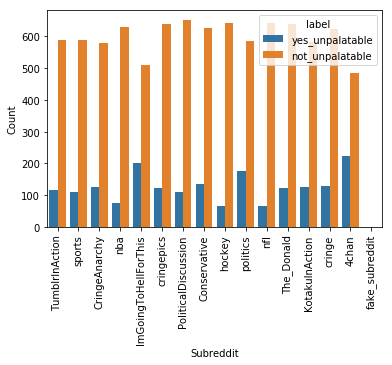

In [15]:
p = sns.countplot(x='subreddit', hue='label', data=df)
p.set_xlabel('Subreddit')
p.set_ylabel('Count')
p.tick_params(axis='x', rotation=90)